In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import traceback
from glob import glob

import sys
sys.path.append("../")

from electronfactors.inputs.convert_merge_guess import convert_merge_guess
from electronfactors.model.initialise import create_cache

from electronfactors.ellipse.equivalent import EquivalentEllipse

from electronfactors.model.iteration import iteration

# from electronfactors.model.display_cutouts import display_cutouts

In [2]:
# convert_merge_guess()

In [3]:
# energy_list = [6, 9, 12, 15, 18]
# app_list = [6, 10, 14, 20, 25]

energy_list = [18]
app_list = [10]

for energy in energy_list:
    for applicator in app_list:
        try:
            create_cache(energy=energy, applicator=applicator)
        except:
            print("Energy = %d\nApplicator = %d\n" % (energy, applicator))
            traceback.print_exc()

In [4]:
# for filepath in model_filepaths:
#     try:
#         iteration(filepath=filepath, n=3)
#     except:
#         print("Energy = %d\nApplicator = %d\n" % (energy, applicator))
#         traceback.print_exc()
    

In [5]:
model_filepaths = glob("model_cache/*")
filepath = model_filepaths[1]
filepath

'model_cache/6MeV_14app_100ssd.yml'

P33:


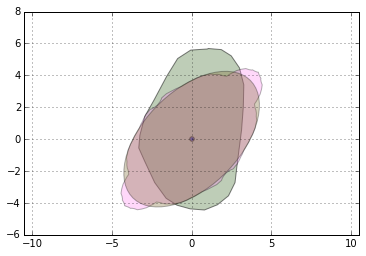

P20:


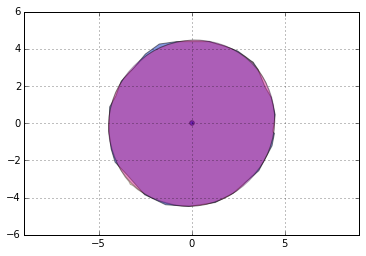

P23:


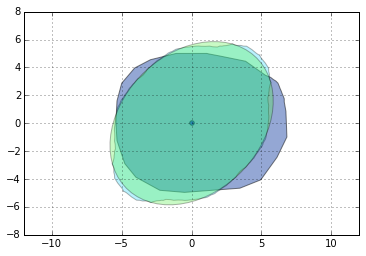

P35_1:


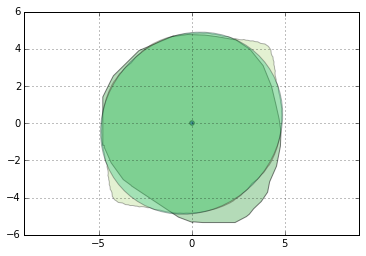

P38_3:


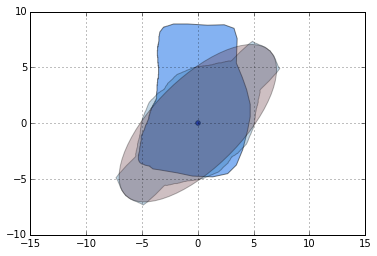

In [6]:
iteration(filepath=filepath, debug=True)

